In [25]:
#Basic python libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

In [26]:
pip install WordCloud

In [27]:
#Natural language processing libraries
import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

In [28]:
#Scikit learn (machine learning library)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [29]:
#Evaluation Metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report


In [30]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

In [31]:
df = pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

In [32]:
print(df.shape)

(18000, 2)


In [33]:
print(df.sample(5))

                                                    text    label
8545   i always feel like im entirely pathetic and ne...  sadness
6934   i came to a theory whereby even if you feel th...  sadness
14438    im not feeling all that happy or thankful today      joy
10013  i finally found this afternoon and i wear it f...    anger
7290     i am feeling fine i take suppliments for health      joy


<Axes: xlabel='count', ylabel='label'>

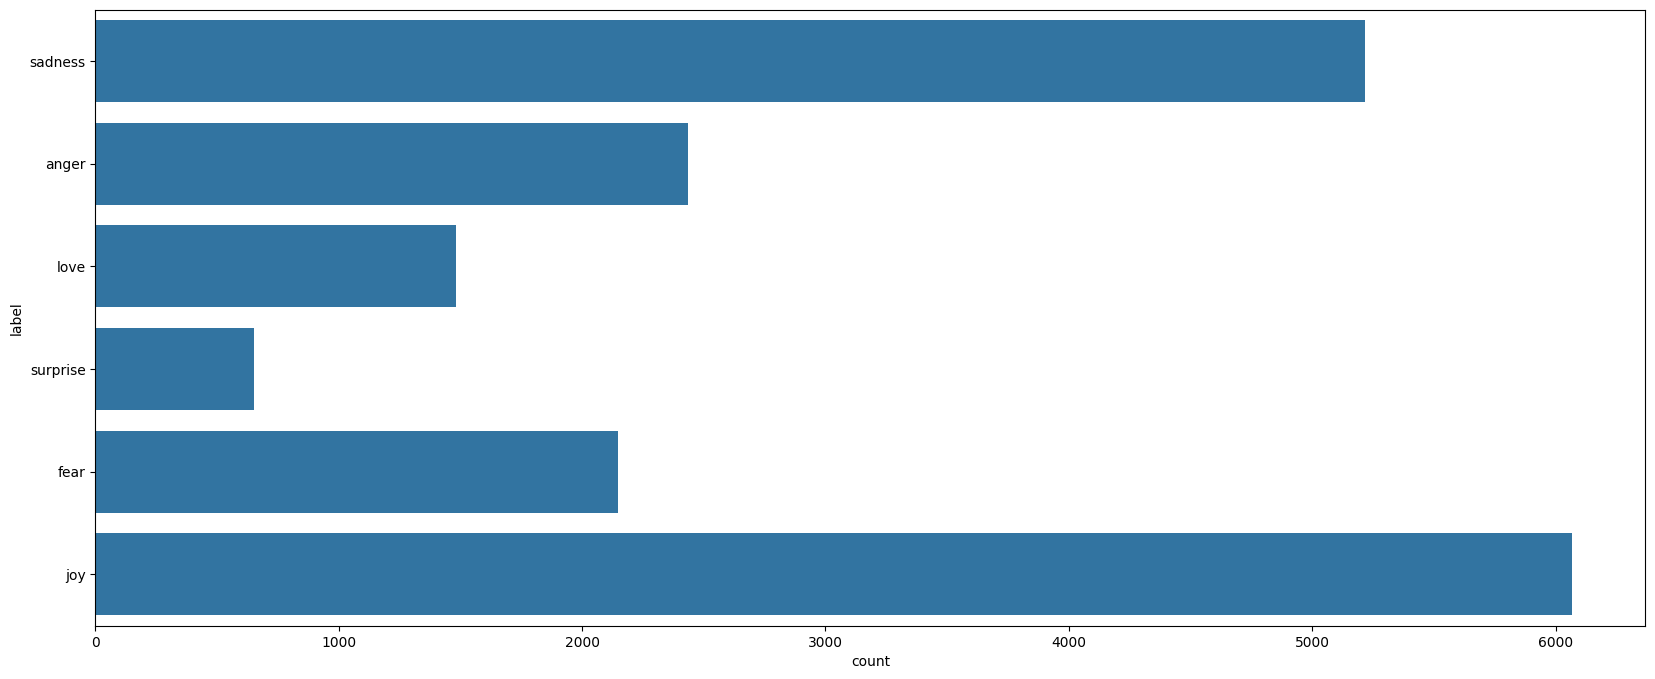

In [34]:
sns.countplot(df['label'])

In [35]:
#convert to two classes - positive and negative sentiment
def custom_encoder(df):
    df.replace(to_replace='surprise',value=1,inplace=True)
    df.replace(to_replace='love',value=1,inplace=True)
    df.replace(to_replace='joy',value=1,inplace=True)
    df.replace(to_replace='fear',value=0,inplace=True)
    df.replace(to_replace='anger',value=0,inplace=True)
    df.replace(to_replace='sadness',value=0,inplace=True)
    return df

In [36]:
custom_encoder(df['label'])

C:\Users\sures\AppData\Local\Temp\ipykernel_23380\1886498892.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(to_replace='sadness',value=0,inplace=True)


0        0
1        0
2        0
3        1
4        0
        ..
17995    0
17996    1
17997    1
17998    1
17999    1
Name: label, Length: 18000, dtype: int64

In [37]:
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0
...,...,...
17995,im having ssa examination tomorrow in the morn...,0
17996,i constantly worry about their fight against n...,1
17997,i feel its important to share this info for th...,1
17998,i truly feel that if you are passionate enough...,1


In [38]:
#object of WordNetLemmatizer
lm = WordNetLemmatizer()

In [39]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [40]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sures\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
corpus = text_transformation(df['text'])

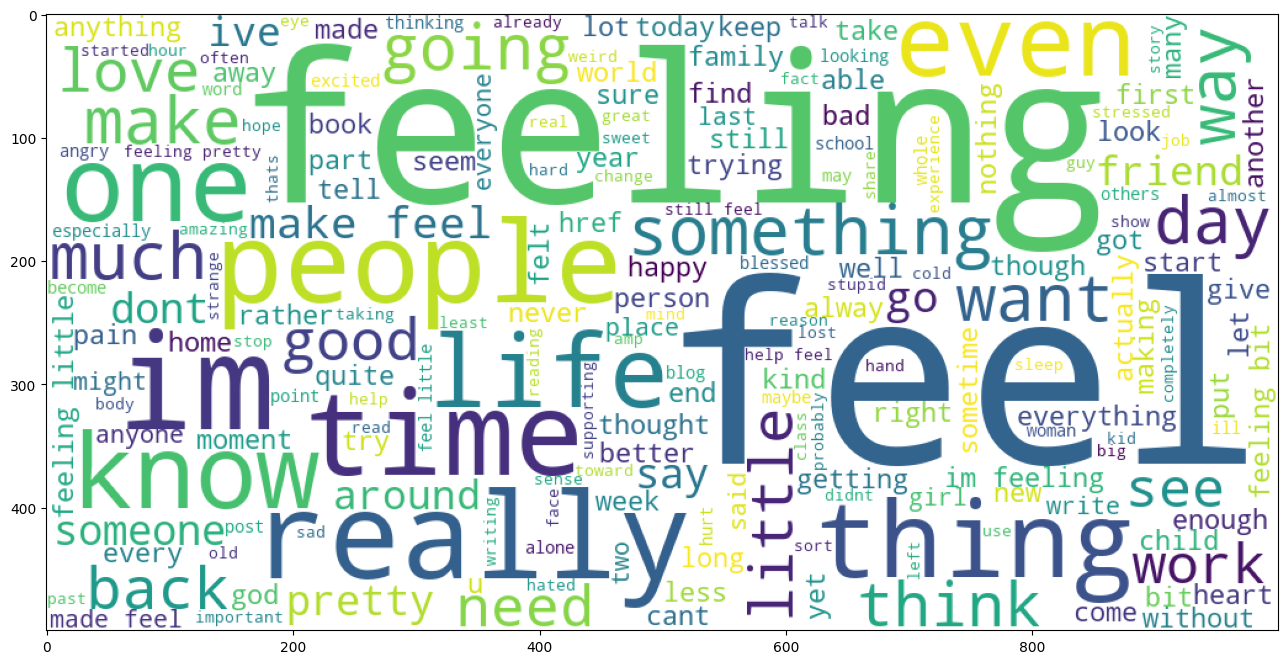

In [42]:
#WordCloud
import matplotlib as mlp
mlp.rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [43]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)
X = traindata
y = df.label

In [44]:
#hyper paramater tuning
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000, 1500],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

In [ ]:
for i in range(432):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

In [ ]:
rfc_model = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],                                  max_depth=grid_search.best_params_['max_depth'],
                                  n_estimators=grid_search.best_params_['n_estimators'],                                      min_samples_split=grid_search.best_params_['min_samples_split'],                                    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                    bootstrap=grid_search.best_params_['bootstrap'])
rfc_model.fit(X,y)

In [ ]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])

In [ ]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc_model.predict(testdata)

In [ ]:
mlp.rcParams['figure.figsize'] = 10,5
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

In [ ]:
predictions_probability = rfc_model.predict_proba(testdata)
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [ ]:
# function to take the input statement and perform the same transformations we did earlier
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc_model.predict(transformed_input)
    expression_check(prediction)

In [ ]:
input1 = ["I don't like to waste my time on social media,it's time consuming."]
input2 = ["I bought a new phone and it's very heavy."]

In [ ]:
sentiment_predictor(input1)
sentiment_predictor(input2)

In [ ]:
import pickle

with open("new_model.pkl", "wb") as file:
    pickle.dump(rfc_model, file)

NameError: name 'rfc_model' is not defined